In [2]:
import sys
nb_out = sys.stdout
import tsaugmentation as tsag
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import groupby
import seaborn as sns
sys.stdout = nb_out
plt.style.use('bmh')

Importing the tsaugmentation module. L. Roque. 
    Method to Test the Robustness of Hierarchical Time Series Forecasting Algorithms.



In [4]:
data = tsag.preprocessing.PreprocessDatasets('tourism').apply_preprocess()

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [5]:
dataset = data['train']['data']

# Problem Statement

We are interested in computing drift detection across a time series dataset and understand how many concept drift we can find. After that, we will transform the time series (only the training component) using different random perturbations. After the perturbations have been applied, we will compute once again the same concept drift detection and see how many more concept drift can we detect. We will then do the same approach but only focused on the test set, i.e. checking if between train and test concept drift has occured and how many times. This method will help motivate the reasoning behind applying transformations to our dataset, since we impacting the data distribution and hence increase our understanding of how robust an algorithm is in a scenario much closer to the real world.

### Parameters

In [6]:
n = dataset.shape[0]  # number of observations in each time series
m = dataset.shape[1]  # number of time series

window_size = 24      # window_size(int): Size of a concept window, no less than 10.
                      # window_size equals should equal 2-5 periods
            
rolling_window = 3    # rolling_window(int): Smoothing window size, belongs to [1, window_size]

step = 12             # step(int): The jump length of the sliding window, belongs to [1, window_size]

res_size = 50         # The number of reservoir nodes of the ESN model (if it is equal to m, the time series are perfectly reconstructed)
in_size = window_size
out_size = window_size

threshold_index = 2.0 # multiple of inter-quartile range to define what is a concept drift

## Preprocess data

In [7]:
def data_preprocess(data, rolling_window):
    data_av = np.zeros((data.shape[0]-rolling_window + 1, data.shape[1]))
    # Moving average
    for i in range(data.shape[1]):
        data_av[:,i] = np.convolve(data[:, i],
                             np.ones((rolling_window,)) / rolling_window, 'valid')
        
    return data_av

In [8]:
dataset = data['train']['data']

In [9]:
data_av = data_preprocess(dataset, rolling_window)

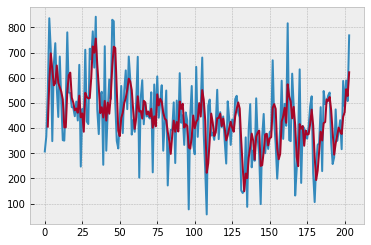

In [10]:
plt.plot(dataset[:,0])
plt.plot(np.arange(rolling_window - 1, data['train']['data'][:,0].shape[0]), data_av[:,0]);

In [11]:
data_av = np.concatenate((data_av, data_av[-(rolling_window-1):]), axis=0)
data_av = (data_av - data_av.min(axis=0)) / (data_av.max(axis=0) - data_av.min(axis=0))

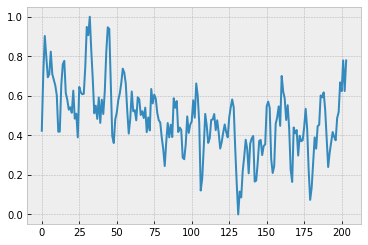

In [12]:
plt.plot(np.arange(data_av[:,0].shape[0]), data_av[:,0]);

## Methods

We are working on a unsupervised scenario, where no labels are available to the predictive model.

![alt text](problem_statement.png)

We will use a Echo State Network (ESNs) which is a simple type of RNNs and can avoid non-converging and computationally expensive by applying least square problem as the alternative training methood. We use it as an auto-encoder to extract features from the time series. We select two adjacent time windows and compare its features (model parameters of the ESN network). Based on the comparison, we are able to understand if concept drift occurred.

![alt text](ESN.png)

In [13]:
def w_generate(res_size, in_size, input_data):
    """
    Randomly generate weights of the ESN
    Args:
        res_size(int): The number of reservoir nodes
        in_size(int): The input size of reservoir model
        input_data(numpy.ndarray): Input data
    Returns:
        x_state(numpy.ndarray): The state of reservoir
    """
    # Weight generates randomly
    np.random.seed(42)
    w_in = np.random.rand(res_size, in_size) - 0.5
    w_0 = np.random.rand(res_size, res_size) - 0.5
    w_0 *= 0.8
    a_speed = 0.3
    
    # Reservoir state
    x_state = np.zeros((res_size, input_data.shape[1]))
    for _ in range(50):
        x_state = (1 - a_speed)*x_state + \
                  a_speed*np.tanh(np.dot(w_in, input_data) + np.dot(w_0, x_state))
    return x_state

In [14]:
def feature_extraction(window_data):
    """
    Extract features of the reservoir model
    Args:
            window_data(numpy.ndarray): The input data (in one window)
    Returns:
        w_out(numpy.darray): The trained output weight of the reservoir model
        x_state(numpy.ndarray): The state of reservoir
    """
    # Initialize weights
    x_state = w_generate(res_size, in_size, window_data)
    x_state_t = x_state.T
    
    reg = 1e-8
    
    # Calculate w_out
    w_out = np.dot(np.dot(window_data, x_state_t),
                   np.linalg.inv(np.dot(x_state, x_state_t) + reg*np.eye(res_size)))
    
    return w_out, x_state

In [15]:
def concept_distance(data_x, data_y):
    """
    Calculate the distance of two blocks
    Args:
        data_x(numpy.ndarray): Data x.
        data_y(numpy.ndarray): Data y.
    Returns:
        distance_score(float): Distance between data_x and data_y
    """
    # Feature extraction
    feature_x = feature_extraction(data_x)
    feature_y = feature_extraction(data_y)
    # Calculate distance
    distance_wx = np.sum(abs(np.dot(feature_x[0], feature_x[1])
                          - np.dot(feature_y[0], feature_y[1])), axis=0)/len(data_x)
    statistic_feature = abs(data_x.mean(axis=0) - data_y.mean(axis=0))
    distance_score = (distance_wx + statistic_feature) / (1 + distance_wx + statistic_feature)
    return distance_score

In [16]:
data_x = data_av[0: 0 + window_size]
data_y = data_av[0 + window_size:0 + 2*window_size]

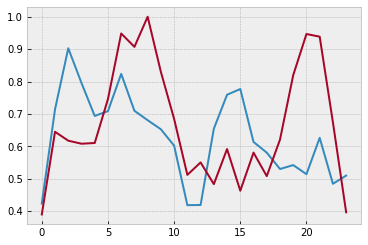

In [17]:
plt.plot(data_x[:,0])
plt.plot(data_y[:,0]);

In [18]:
data_x_features = feature_extraction(data_x)
data_y_features = feature_extraction(data_y)

In [19]:
data_x_features[0].shape

(24, 50)

In [20]:
data_x_features[1].shape

(50, 304)

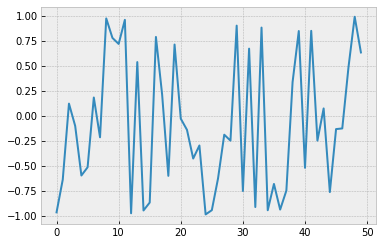

In [39]:
plt.plot(data_x_features[1][:,0]);

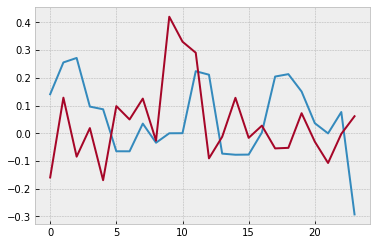

In [42]:
plt.plot(data_x_features[0][:,0])
plt.plot(data_x_features[0][:,1]);

In [46]:
data_x_features[1].shape

(50, 304)

In [43]:
data_x_features[0].shape

(24, 50)

In [45]:
np.dot(data_x_features[0], data_x_features[1]).shape

(24, 304)

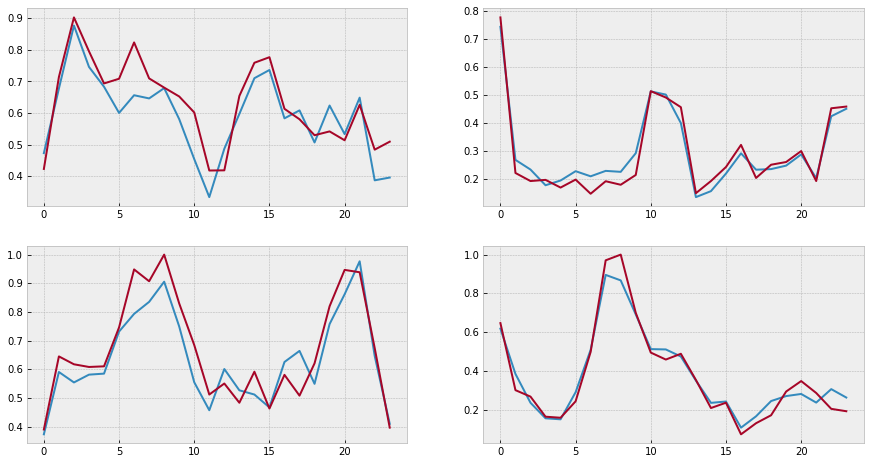

In [22]:
_, ax = plt.subplots(2, 2, figsize=(15, 8))

ax = ax.ravel()

ax[0].plot(np.dot(data_x_features[0], data_x_features[1])[:,0])
ax[0].plot(data_x[:,0]);

ax[1].plot(np.dot(data_x_features[0], data_x_features[1])[:,1])
ax[1].plot(data_x[:,1]);

ax[2].plot(np.dot(data_y_features[0], data_y_features[1])[:,0])
ax[2].plot(data_y[:,0]);

ax[3].plot(np.dot(data_y_features[0], data_y_features[1])[:,1])
ax[3].plot(data_y[:,1]);

In the reservoir model there are trained weights `w_out` and non-trained `x_state`. Notice that multiplying `w_out` and `x_state` gets us close to the true time series. Seems that the `x_state` is what defines how close you would be for a time series. 

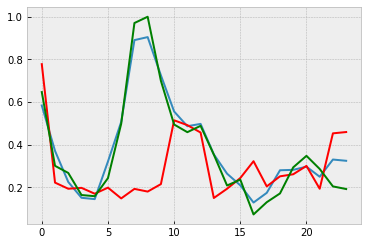

In [23]:
plt.plot(np.dot(data_x_features[0], data_y_features[1])[:,1])
plt.plot(data_x[:,1], color='r');
plt.plot(data_y[:,1], color='g');

This happens because the encoding is happening at the `x_state` for each time series window and `w_out` is very similar between time series (at least for similar time series).

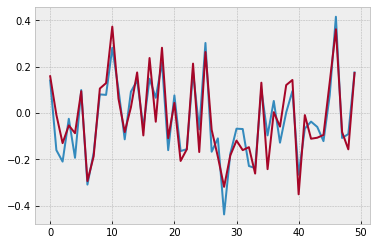

In [24]:
plt.plot(data_x_features[0][0,:])
plt.plot(data_y_features[0][0,:]);

In [25]:
def concept_drift_check(data, n, m):
    """
    Compute the drift score for every time series
    Args:
        data(numpy.ndarray): Input data after processing
        n: number of observations
        m: number of time series
    Returns:
        drift_score(numpy.ndarray)(nxm): Drift score for every time series
    """
    drift_score = np.zeros((n, m))

    for i in range(0, n - 2*window_size, step):
        data_x = data[i: i + window_size]
        data_y = data[i + window_size:i + 2*window_size]
        drift_score[i + window_size,:] = concept_distance(data_x, data_y)
        
    return drift_score

In [26]:
drift_score = concept_drift_check(data_av, n, m)

In [27]:
drift_score.shape

(204, 304)

In [28]:
drift_score_nan = drift_score.copy()
drift_score_nan[drift_score_nan==0] = np.nan

## Experimental Setup and Results

In [29]:
def compute_threshold(drift_score, threshold_index, m):
    """
    Calculate the threshold of concept drift
    Args:
        drift_score(numpy.ndarray): The drift score for a dataset of time series
        threshold_index(float): Threshold adjusted index, [-∞, +∞]
    Returns:
        threshold(numpy.ndarray): Array with 
    """
    threshold = np.zeros((m,))

    for series in range(m):
        distance = drift_score[:,series]
        distance = distance[distance > 0]

        # Threshold calculation
        if distance.size > 0:
            q_1 = np.percentile(distance, 25)
            q_3 = np.percentile(distance, 75)
            q_diff = q_3 - q_1
            threshold[series] = np.clip(np.percentile(distance, 50) + threshold_index*q_diff, 0, 1)
        else:
            threshold[series] = 1
            
    return threshold

In [30]:
threshold = compute_threshold(drift_score, threshold_index, m)

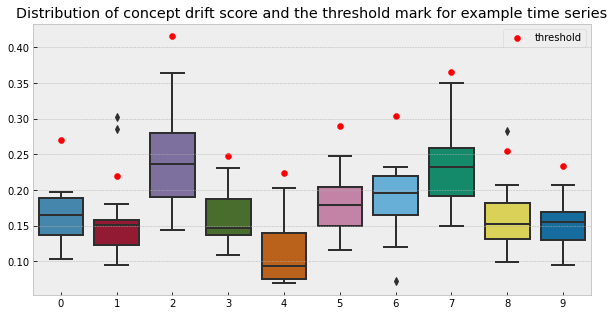

In [31]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.boxplot(data=drift_score_nan[:,:10], ax=ax)
plt.scatter(np.arange(10), threshold[:10], color='r', marker='o', label='threshold')
plt.title('Distribution of concept drift score and the threshold mark for example time series')
plt.legend();

In [32]:
def get_labels(original_data, threshold, drift_score, window_size, step_size):
    """
    Obtain the drift label of the dataset of time series
    Args:
        original_data(numpy.ndarray): The input data
        threshold(float): The drift threshold
        drift_score(numpy.ndarray): The drift score of the input data
        window_size(int): Size of a concept window
            Usually 3 periods of the input data if it is periodic
        step_size(int): The jump length of the sliding window
    Returns:
        label(list): The drift label of input data
            0 means no drift, and 1 means drift happens
        label_location(list): The locations of drifts(x-axis)
    """
    label = np.zeros((n, m))
    label_location = np.zeros((n, m))
    # Label: label=0, no drifts; label=1, drift happens.
    for series in range(dataset.shape[1]):
        for i in range(0, n - 2*window_size, step_size):
            label_location[i,series] = i + window_size
            if drift_score[i + window_size, series] >= threshold[series]:
                label[i,series]=1
            else:
                label[i,series]=0
    return label, label_location

In [33]:
label, label_location = get_labels(data_av, threshold, drift_score, window_size, step)

In [71]:
def plot_results(original_data, threshold, concept_location, drift_point, drift_score, series):
    """
    Plot the results
    Args:
        original_data(numpy.ndarray): The input data.
        threshold(float): The concept drift threshold.
        concept_location(list): The concept drift locations(x-axis).
        drift_point(list): The precise drift point of a drift.
        drift_score(numpy.ndarray): The drift score of input data.
    """
    plt.figure(figsize=(20, 8))
    plt.subplot(2, 1, 1)
    # Plot input data and drift points
    plt.plot(original_data[:,series], label="data")
    plt.title('Concept drift check')
    drift_x = label[:,series]*concept_location[:,series]
    drift_x[drift_x == 0] = np.nan
    plt.scatter(drift_x, np.zeros(len(label)),
                marker='o', s=200, color="b", label="concept drift occurred")
    #for _, i in enumerate(drift_point[:,series]):
    #    plt.axvline(x=i, color='r', linestyle='--')
    plt.legend(fontsize=15)
    plt.subplot(2, 1, 2)
    # Plot drift score
    plt.plot(drift_score[:,series], label="drift_score")
    plt.axhline(y=threshold[series], color='r', linestyle='--', label="threshold")
    plt.legend(fontsize=15)

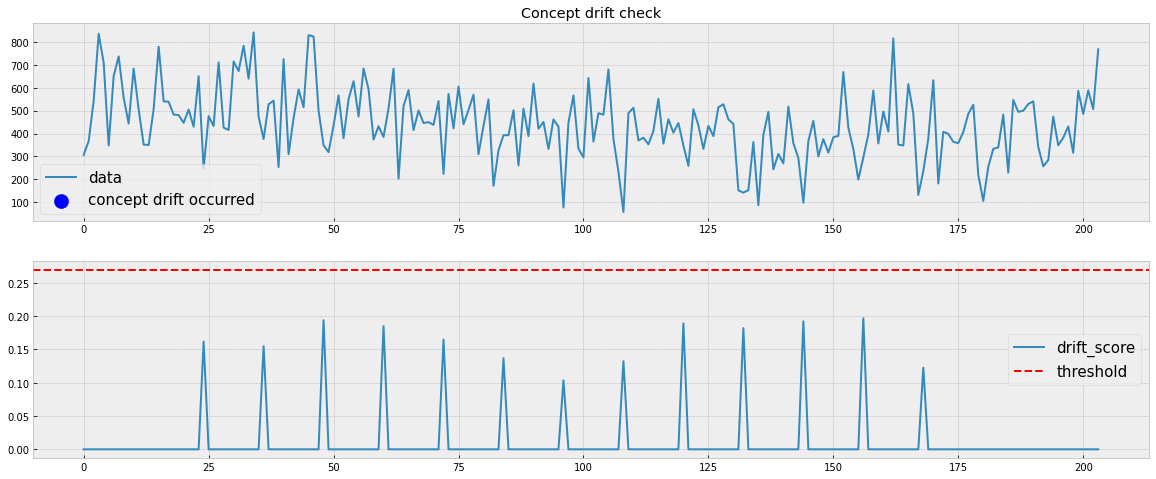

In [72]:
plot_results(dataset, threshold, label_location, label, drift_score, 0)

Example of the time series with most concept drifts.

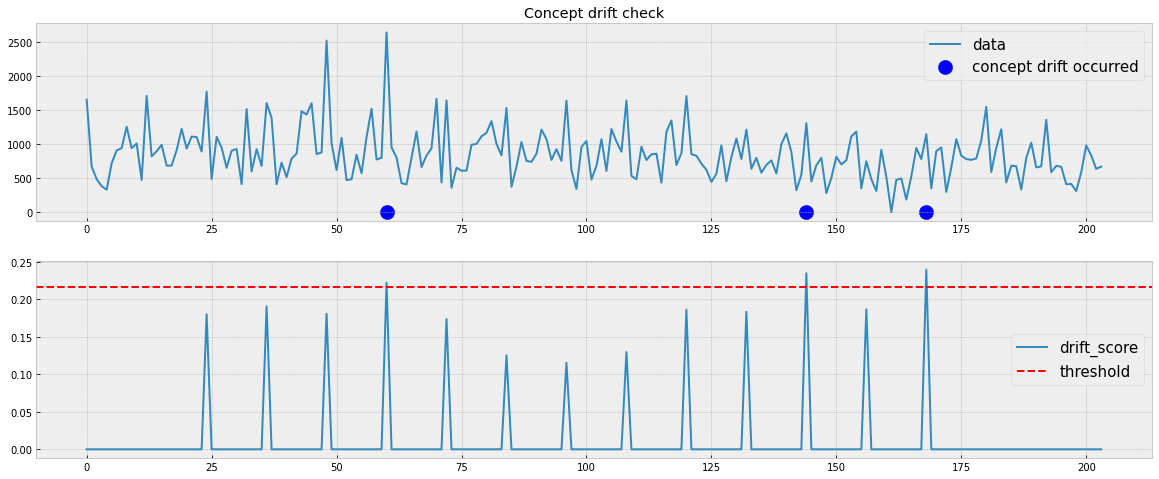

In [73]:
plot_results(dataset, threshold, label_location, label, drift_score, np.argmax(label.sum(axis=0)))

Number of concept drift changes across the whole dataset with the threshold defined above.

In [74]:
label.sum()

98.0

In [75]:
drift_score.max()

0.4636710334872319

## Next Steps

### Compute concept drift between several windows in the training dataset and the test dataset
### Prove that by performing the transformations we have a bigger number of concept drift ocurring between train and test